# Day 8 Analysis

For Day 8, let's look at the relationship between target share and fantasy points for receivers and see who might be due for a positive or negative regression to the mean.

## Set Up

In [155]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
from os import path
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create database connection
conn = sqlite3.connect('../data/db/database.db')

## Target Share vs. Fantasy Points
Let's get target share and fantasy points scored for receivers going back to 1999. We should see a positive relationship – as target share increase, fantasy points scored should increase as well.

In [114]:
query = """
SELECT
    player_id,
    player_display_name AS player_name,
    season,
    week,
    receptions,
    targets,
    (1.0 * receptions/targets) AS tgt_conv,
    receiving_yards AS yds,
    receiving_tds AS tds,
    receiving_air_yards AS air_yds,
    receiving_yards_after_catch AS yac,
    ROUND(target_share,3) AS tgt_share,
    ROUND(air_yards_share,3) AS air_yds_share,
    ROUND(fantasy_points,2) AS fantasy_pts,
    ROUND(fantasy_points_ppr,2) AS fantasy_pts_ppr
FROM weekly 
WHERE position = 'WR'
    AND season_type = 'REG'
"""

df_all = pd.read_sql(query, conn)

print(df_all.shape)
df_all.head()

(43959, 15)


,player_id,player_name,season,week,receptions,targets,tgt_conv,yds,tds,air_yds,yac,tgt_share,air_yds_share,fantasy_pts,fantasy_pts_ppr
0,00-0000145,Derrick Alexander,1999,1,6,10,0.600000,154.0,1,0.0,0.0,0.244,0.0,21.4,27.4
1,00-0000145,Derrick Alexander,1999,2,6,7,0.857143,117.0,0,0.0,0.0,0.412,0.0,11.7,17.7
2,00-0000145,Derrick Alexander,1999,3,3,6,0.500000,69.0,0,0.0,0.0,0.207,0.0,6.9,9.9
3,00-0000145,Derrick Alexander,1999,4,1,7,0.142857,14.0,0,0.0,0.0,0.194,0.0,1.4,2.4
4,00-0000145,Derrick Alexander,1999,5,2,5,0.400000,25.0,0,0.0,0.0,0.200,0.0,2.5,4.5


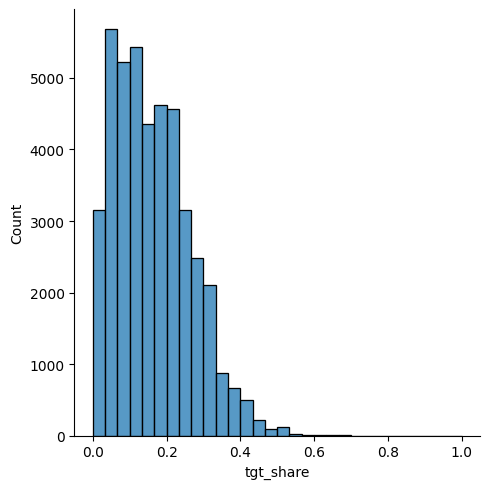

In [96]:
# Check distribution
sns.displot(
    x="tgt_share",
    data=df_all,
    kind="hist",
    bins = 30
)

In [92]:
df_all[df_all['tgt_share'] == 0]

,player_id,player_name,season,week,receptions,targets,yds,tds,air_yds,yac,tgt_share,air_yds_share,fantasy_pts,fantasy_pts_ppr
10447,00-0022124,Taylor Jacobs,2004,3,0,0,0.0,0,0.0,0.0,0.0,0.0,2.0,2.0
10638,00-0022889,Reggie Williams,2004,6,0,0,0.0,0,0.0,0.0,0.0,0.0,2.0,2.0
24843,00-0029702,Juron Criner,2012,9,0,0,0.0,0,0.0,0.0,0.0,0.0,2.0,2.0
40450,00-0036182,Nick Westbrook-Ikhine,2020,6,0,0,0.0,0,0.0,0.0,0.0,0.0,2.0,2.0


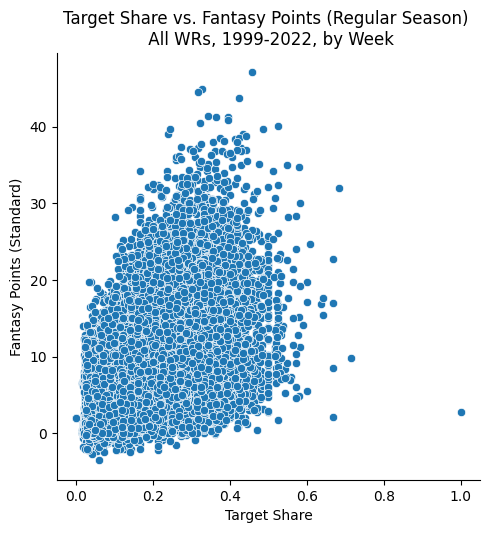

In [148]:
g = sns.relplot(
    x="tgt_share",
    y="fantasy_pts",
    data=df_all
)

g.set(
    xlabel="Target Share", 
    ylabel="Fantasy Points (Standard)",
    title="Target Share vs. Fantasy Points (Regular Season) \n All WRs, 1999-2022, by Week"
)

In [150]:
print(f"Correlation Coefficient: {df_all['tgt_share'].corr(df_all['fantasy_pts'])}")

Correlation Coefficient: 0.606503039715833


I'll group by player to remove outliers and verify that the relationship holds over the cours eof a season and a player's career

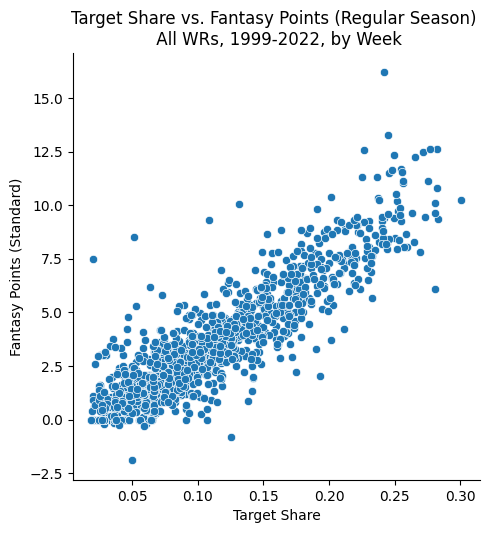

In [167]:
# Aggregate
# Manually specify which aggregation function to use
df_avg = df_all.groupby(['player_id', 'player_name']).mean().reset_index()

# Plot
g = sns.relplot(
    x="tgt_share",
    y="fantasy_pts",
    data=df_avg
)

g.set(
    xlabel="Target Share", 
    ylabel="Fantasy Points (Standard)",
    title="Target Share vs. Fantasy Points (Regular Season) \n All WRs, 1999-2022, by Week"
)

In [168]:
print(f"Correlation Coefficient: {df_avg['tgt_share'].corr(df_avg['fantasy_pts'])}")

Correlation Coefficient: 0.8850034712230509


In [172]:
col_order = [
    'player_name', 'season', 'week', 'receptions', 'targets', 'yds', 'tds',
    'air_yds', 'yac', 'tgt_share', 'air_yds_share', 'fantasy_pts', 'fantasy_pts_ppr']

df_avg = df_avg.sort_values('fantasy_pts', ascending=False)[col_order].reset_index(drop=True)

df_avg.head(5)


,player_name,season,week,receptions,targets,yds,tds,air_yds,yac,tgt_share,air_yds_share,fantasy_pts,fantasy_pts_ppr
0,Kristian Wilkerson,2021.000000,17.000000,4.000000,8.000000,42.000000,2.000000,132.000000,5.000000,0.242000,0.534000,16.200000,20.200000
1,Ja'Marr Chase,2021.291667,7.875000,5.333333,8.416667,85.833333,0.791667,95.041667,38.500000,0.244792,0.369208,13.262500,18.595833
2,Cory Ross,2007.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,13.200000,13.200000
3,Justin Jefferson,2020.775000,8.475000,6.200000,9.075000,94.200000,0.475000,101.925000,31.675000,0.276975,0.424375,12.625500,18.825500
4,Marvin Harrison,2003.198630,8.938356,6.191781,8.698630,82.664384,0.732877,12.191781,3.609589,0.282356,0.065123,12.608904,18.800685


In [107]:
df_avg.sort_values('tgt_share', ascending=False)

,player_name,season,week,receptions,targets,yds,tds,air_yds,yac,tgt_share,air_yds_share,fantasy_pts,fantasy_pts_ppr
23,Jimmy Smith,2001.981308,9.383178,5.579439,8.971963,77.093458,0.420561,0.000000,0.000000,0.300869,0.000000,10.231776,15.811215
39,Rod Smith,2002.536000,8.920000,5.336000,8.112000,68.464000,0.376000,2.936000,1.144000,0.282808,0.026584,9.355840,14.691840
4,Marvin Harrison,2003.198630,8.938356,6.191781,8.698630,82.664384,0.732877,12.191781,3.609589,0.282356,0.065123,12.608904,18.800685
18,DeAndre Hopkins,2016.884058,8.673913,5.876812,9.413043,78.572464,0.500000,111.927536,20.992754,0.282022,0.385935,10.809710,16.686522
212,Drake London,2022.000000,4.500000,3.750000,6.125000,43.250000,0.250000,61.500000,13.750000,0.280500,0.288250,6.075000,9.825000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1011,John Franklin,2019.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,1.100000,1.100000
1070,Reggie McNeal,2006.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,0.800000,0.800000
1146,Maurice Ffrench,2021.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,0.300000,0.300000
1212,Alex Bachman,2021.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,-0.300000,-0.300000


## Air Yards vs. Fantasy Points: 2022

In [115]:
f_2022 = df_all['season'] == 2022

df_2022 = df_all[f_2022].groupby('player_id').mean()

df_2022 = df_2022.sort_values('fantasy_pts', ascending=False) \
    .reset_index() \
    .merge(
        df_all[['player_id','player_name']].drop_duplicates(), 
        how='left'
    )[col_order]

print(df_2022.shape)
df_2022.head(10)

(198, 4)


/var/folders/pr/phs5jp1d143fx1t05hqzwt580000gn/T/ipykernel_50613/2663815752.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_2022 = df_all[f_2022].groupby('player_id').mean()


,player_name,tgt_share,fantasy_pts,fantasy_pts_ppr
0,Stefon Diggs,0.287429,16.914286,24.771429
1,DeAndre Hopkins,0.392500,16.100000,27.100000
2,Cooper Kupp,0.324714,15.385714,24.528571
3,Tyreek Hill,0.321375,13.825000,22.450000
4,Justin Jefferson,0.290286,13.774286,21.202857
5,A.J. Brown,0.318429,13.700000,19.271429
6,Ja'Marr Chase,0.275143,13.528571,20.242857
7,Jaylen Waddle,0.216875,12.800000,18.050000
8,Michael Thomas,0.201000,11.700000,17.033333
9,Davante Adams,0.296429,11.585714,17.014286


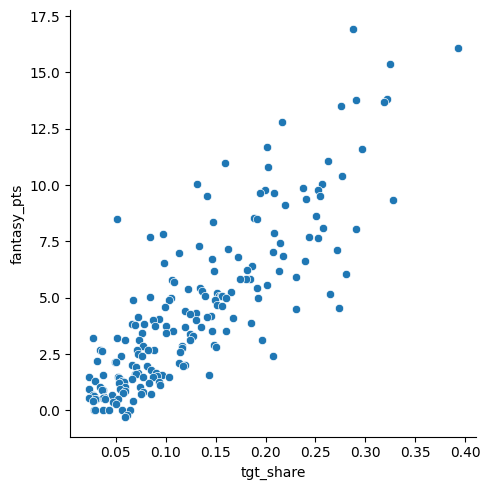

In [112]:
sns.relplot(
    x="tgt_share",
    y="fantasy_pts",
    data=df_2022
)

In [118]:
col_order = ['player_name',
       'tgt_share', 'fantasy_pts',
       'fantasy_pts_ppr']

df_2022.sort_values('tgt_share', ascending=False)[col_order].head(10)

,player_name,tgt_share,fantasy_pts,fantasy_pts_ppr
1,DeAndre Hopkins,0.392500,16.100000,27.100000
24,CeeDee Lamb,0.327750,9.350000,14.600000
2,Cooper Kupp,0.324714,15.385714,24.528571
3,Tyreek Hill,0.321375,13.825000,22.450000
5,A.J. Brown,0.318429,13.700000,19.271429
9,Davante Adams,0.296429,11.585714,17.014286
32,D.J. Moore,0.290500,8.050000,12.175000
4,Justin Jefferson,0.290286,13.774286,21.202857
0,Stefon Diggs,0.287429,16.914286,24.771429
53,Drake London,0.280500,6.075000,9.825000


Let's go a step further and use linear regression to get an idea of expected average fantasy points given target share. With this we can see how much each player is under or over-performing.

## Use Linear Regression to find under and over-performers through Week 8

In [120]:


fit = np.polyfit(df_all['tgt_share'], df_all['fantasy_pts'], 1)
# lin_func_fpts = np.poly1d(fit)

 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  5 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value


LinAlgError: SVD did not converge in Linear Least Squares

In [122]:
# Check for null-vales
df_all[['tgt_share','fantasy_pts']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43959 entries, 0 to 43958
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   tgt_share    43278 non-null  float64
 1   fantasy_pts  43959 non-null  float64
dtypes: float64(2)
memory usage: 687.0 KB


In [124]:
# Drop null values
df_all_no_null = df_all.dropna(subset=['tgt_share', 'fantasy_pts'])

fit = np.polyfit(
    x=df_all_no_null['tgt_share'], 
    y=df_all_no_null['fantasy_pts'], 
    deg=1)

lin_func_fpts = np.poly1d(fit)

In [138]:
summary_2022 = df_2022.sort_values('tgt_share', ascending=False)[col_order]

summary_2022['expected_fantasy_pts'] = lin_func_fpts(summary_2022['tgt_share'])
summary_2022['perf'] = summary_2022['fantasy_pts'] - summary_2022['expected_fantasy_pts']

summary_2022.head(10)

,player_name,tgt_share,fantasy_pts,fantasy_pts_ppr,expected_fantasy_pts,perf
1,DeAndre Hopkins,0.392500,16.100000,27.100000,13.943255,2.156745
24,CeeDee Lamb,0.327750,9.350000,14.600000,11.659476,-2.309476
2,Cooper Kupp,0.324714,15.385714,24.528571,11.552404,3.833310
3,Tyreek Hill,0.321375,13.825000,22.450000,11.434625,2.390375
5,A.J. Brown,0.318429,13.700000,19.271429,11.330703,2.369297
9,Davante Adams,0.296429,11.585714,17.014286,10.554747,1.030967
32,D.J. Moore,0.290500,8.050000,12.175000,10.345642,-2.295642
4,Justin Jefferson,0.290286,13.774286,21.202857,10.338084,3.436202
0,Stefon Diggs,0.287429,16.914286,24.771429,10.237311,6.676975
53,Drake London,0.280500,6.075000,9.825000,9.992935,-3.917935


In [139]:
summary_2022.sort_values('perf').head(10).round(2)

,player_name,tgt_share,fantasy_pts,fantasy_pts_ppr,expected_fantasy_pts,perf
82,Darnell Mooney,0.27,4.55,7.68,9.74,-5.19
129,Dezmon Patmon,0.21,2.40,4.40,7.40,-5.00
67,Diontae Johnson,0.26,5.18,10.55,9.44,-4.26
53,Drake London,0.28,6.08,9.82,9.99,-3.92
113,Equanimeous St. Brown,0.20,3.12,4.62,7.02,-3.89
83,Robert Woods,0.23,4.51,7.66,8.24,-3.73
146,Marcus Johnson,0.14,1.58,3.08,5.14,-3.57
94,Michael Gallup,0.19,3.90,6.30,6.65,-2.75
118,Richie James,0.15,2.81,5.67,5.42,-2.61
41,Sterling Shepard,0.27,7.13,11.47,9.69,-2.56
